Kvasir dataset split into neg/pos and trained using Resnet50 without augmentation. Getting some decent results after training on resampled data with large step-size.  
- Class weighting  
- Resampling  
- Initial Bias-estimation
- Decreasing learning rate

### Loading images
https://www.tensorflow.org/tutorials/load_data/images

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import numpy as np
import datetime
import time
import os
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import datetime

# Some stuff to make utils-function work
import sys
sys.path.append('../utils')
from pipeline import create_dataset, split_and_create_dataset, prepare_for_training
from create_model import create_model, create_callbacks
from utils import write_to_file, unpipe
%load_ext autoreload
%autoreload 2

# Jupyter-specific
%matplotlib inline

project_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

Some parameters

In [2]:
data_dir = pathlib.Path('/home/henriklg/master-thesis/data/kvasir-v2/')

dir_name = "resnet50"
experiment = "imbalance"
log_dir = "./logs/{}_{}/{}".format(project_time, experiment, dir_name)

conf = {
    # Dataset
    "data_dir": data_dir,
    "ds_info": 'binary',
    "augment": ["crop","flip","brightness","saturation","contrast","rotate"],
    "aug_mult": 0,
    "resample": False,
    "class_weight": False,
    "shuffle_buffer_size": 2000,        # 0=no shuffling
    "seed": 2511,
    "neg_class": ['normal-cecum'],                 # select neg class for binary ds (normal class)
    "outcast": None,                   # list of folders to drop - currently only works for 1 item
    # Model
    "model": 'EfficientNetB0',
    "weights": None,                   # which weights to initialize the model with
    "dropout": 0.2,
    "num_epochs": 20,
    "batch_size": 16,
    "img_shape": (128, 128, 3),
    "learning_rate": 0.001,
    "optimizer": 'Adam',
    "final_activation": 'sigmoid',     # sigmoid for binary ds
    # Callbacks
    "tensorboard": False,
    "learning_schedule": False,
    "decay_rate": 0,                   # 128:0.25   64:1.0   32:4.0   16:16   8:64
    "checkpoint": False,
    "early_stopp": False,
    "early_stopp_patience": 7,
    # Misc
    "verbosity": 1,
    "keep_threshold": 0.0,
    "log_dir": log_dir,
    "cache_dir": "./cache"
    }

Create training, testing and validation dataset from utils/data_prep.py

In [3]:
train_ds, test_ds, val_ds = split_and_create_dataset(conf)


Negative                    :  1000 | 12.50%
---------------------------------------------
     - normal-cecum         :  1000 | 12.50%

Positive                    :  7000 | 87.50%
---------------------------------------------
     - dyed-resection-margins :  1000 | 12.50%
     - normal-z-line        :  1000 | 12.50%
     - esophagitis          :  1000 | 12.50%
     - normal-pylorus       :  1000 | 12.50%
     - polyps               :  1000 | 12.50%
     - ulcerative-colitis   :  1000 | 12.50%
     - dyed-lifted-polyps   :  1000 | 12.50%

Total number of image       : 8000

Dataset.list_files:  /home/henriklg/master-thesis/data/kvasir-v2/*/*.*g 


Full dataset sample size:         8000
Train dataset sample size:        5600
Test dataset sample size:         1200
Validation dataset sample size:   1200


# Training

### Resnet50 transfer learning
see https://adventuresinmachinelearning.com/transfer-learning-tensorflow-2/  
imbalanced-data: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

In [4]:
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, LearningRateScheduler

In [5]:
metrics = [
        tf.keras.metrics.TruePositives(name='tp'),
        tf.keras.metrics.FalsePositives(name='fp'),
        tf.keras.metrics.TrueNegatives(name='tn'),
        tf.keras.metrics.FalseNegatives(name='fn'), 
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc'),
]

In [6]:
res_net = tf.keras.applications.ResNet50(
                weights='imagenet', 
                include_top=False, 
                input_shape=conf["img_shape"])

res_net.trainable = True

In [7]:
def make_model(output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    
    global_average_layer = GlobalAveragePooling2D()
    output_layer = Dense(1, activation=conf["final_activation"],
                         bias_initializer=output_bias)

    resnet50_model = tf.keras.Sequential([
            res_net,
            global_average_layer,
            output_layer])
    
    if conf['optimizer'] == 'Adam':
        opt = tf.keras.optimizers.Adam(learning_rate=conf["learning_rate"])
    elif conf['optimizer'] == 'SGD':
        opt = tf.keras.optimizers.SGD(learning_rate=conf["learning_rate"])

    resnet50_model.compile(
            optimizer=opt,
            loss=tf.keras.losses.BinaryCrossentropy(),
            metrics=metrics)
    
    return resnet50_model

### Callbacks

In [8]:
callbacks = create_callbacks(conf)

## Set correct initial bias


In [9]:
bias_model = make_model()

# Test run the model and show 10 first predictions of one epoch
bias_model.predict(train_ds.take(1))[:10]

array([[0.16293277],
       [0.17168307],
       [0.16304919],
       [0.1664322 ],
       [0.1710376 ],
       [0.16840544],
       [0.17127007],
       [0.17077428],
       [0.16916844],
       [0.17339005]], dtype=float32)

In [10]:
results = bias_model.evaluate(train_ds, verbose=0, steps=conf["steps"]["train"])
print("Loss: {:0.4f}".format(results[0]))

Loss: 1.5693


In [11]:
initial_bias = np.log([conf["pos_count"]/conf["neg_count"]])
print ("The initial bias should then be: {:.4f}".format(initial_bias[0]))

The initial bias should then be: 1.9459


In [12]:
new_bias_model = make_model(output_bias = initial_bias)
new_bias_model.predict(train_ds, verbose=0, steps=conf["steps"]["train"])

print ("Initial guess should be around:", conf["pos_count"]/conf["sizes"]["total"])
new_bias_model.predict(train_ds.take(1))[:10]

Initial guess should be around: 0.875


array([[0.90670645],
       [0.90782046],
       [0.90734464],
       [0.90825945],
       [0.90485156],
       [0.9049826 ],
       [0.9071683 ],
       [0.9107182 ],
       [0.90555364],
       [0.90877044]], dtype=float32)

In [13]:
results = new_bias_model.evaluate(train_ds, verbose=0, steps=conf["steps"]["train"])
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.3950


In [14]:
initial_weights = os.path.join(conf["log_dir"],'initial_weights')
new_bias_model.save_weights(initial_weights)

#### Confirm that the bias fix helps

In [15]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_loss(history, label, n):
    # Use a log scale to show the wide range of values.
    plt.semilogy(history.epoch,  history.history['loss'],
               color=colors[n], label='Train '+label)
    plt.semilogy(history.epoch,  history.history['val_loss'],
          color=colors[n], label='Val '+label,
          linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend()

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Some functions

In [48]:
def plot_metrics(history):
    metrics =  ['loss', 'auc', 'precision', 'recall']
    plt.figure(figsize=(12, 10))
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()
    plt.tight_layout()

In [18]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    
    metrics_list = np.asarray([['tn', 'fp'], ['fn', 'tp']])
    labels = (np.asarray(["{0}\n{1:.0f}".format(metrics_list,cm) for metrics_list, cm in zip(metrics_list.flatten(), cm.flatten())])).reshape(2,2)
    
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=labels, fmt="", robust=True, annot_kws={'size':16})
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    
    plt.ylim(2,0)

    print('Legitimate Lesions Detected (True Negatives): ', cm[0][0])
    print('Legitimate Lesions Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Lesions Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Lesions Detected (True Positives): ', cm[1][1])
    print('Total Fraudulent Lesions: ', np.sum(cm[1]))
    print()

In [51]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5,20])
    plt.ylim([80,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.tight_layout()

In [20]:
def numpify(dataset, model, samples=4000):
    ds_eval = dataset.unbatch().take(samples)
    labels = []
    images = []
    for img, lab in ds_eval:
        labels.append(lab.numpy())
        images.append(img.numpy())

    pred = model.predict(np.expand_dims(images, axis=0)[-1])
    
    return (labels, pred)

## Baseline

In [21]:
baseline_model = make_model()
baseline_model.load_weights(initial_weights)

baseline_history = baseline_model.fit(
    train_ds,
    steps_per_epoch = conf["steps"]["train"],
    epochs = conf["num_epochs"],
    validation_data = test_ds,
    validation_steps = conf["steps"]["test"],
    validation_freq = 1,
    callbacks = callbacks
)

Epoch 1/20
350/350 [==============================] - 21s 61ms/step - loss: 0.1823 - tp: 9577.0000 - fp: 971.0000 - tn: 1225.0000 - fn: 5027.0000 - accuracy: 0.6430 - precision: 0.9079 - recall: 0.6558 - auc: 0.6652 - val_loss: 0.3603 - val_tp: 1060.0000 - val_fp: 140.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.8833 - val_precision: 0.8833 - val_recall: 1.0000 - val_auc: 0.5051
Epoch 2/20
350/350 [==============================] - 20s 57ms/step - loss: 0.1184 - tp: 4758.0000 - fp: 150.0000 - tn: 582.0000 - fn: 110.0000 - accuracy: 0.9536 - precision: 0.9694 - recall: 0.9774 - auc: 0.9790 - val_loss: 0.3704 - val_tp: 1060.0000 - val_fp: 140.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.8833 - val_precision: 0.8833 - val_recall: 1.0000 - val_auc: 0.5826
Epoch 3/20
350/350 [==============================] - 20s 56ms/step - loss: 0.1090 - tp: 4750.0000 - fp: 119.0000 - tn: 613.0000 - fn: 118.0000 - accuracy: 0.9577 - precision: 0.9756 - recall: 0.975

#### Validate the results

In [22]:
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns

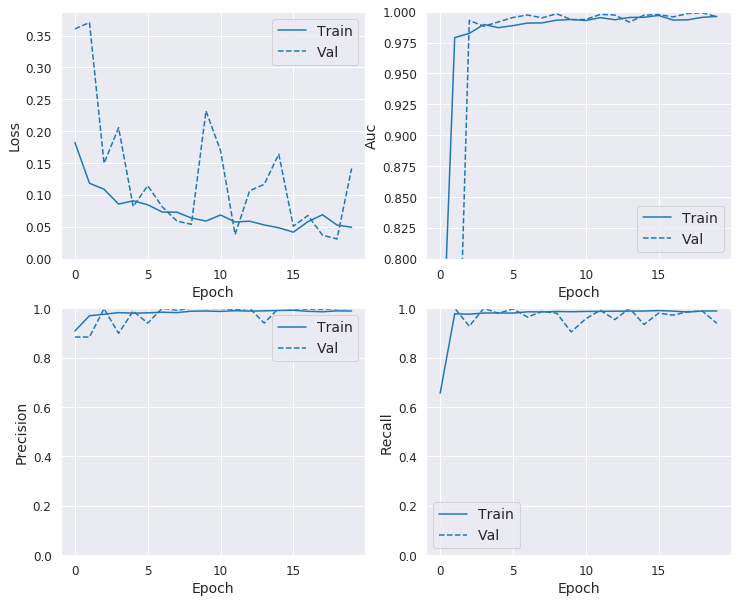

In [23]:
plot_metrics(baseline_history)
plt.savefig(conf["log_dir"]+"/baseline_metrics_plot")

In [24]:
baseline_results = baseline_model.evaluate(val_ds, verbose=2, steps=conf["steps"]["val"])
print()

f = open(conf["log_dir"]+"/baseline_val_results.txt","w")
for name, value in zip(baseline_model.metrics_names, baseline_results):
    line = "{} : {}\n".format(name, value)
    print(line, end='')
    f.write(line)
f.close()
print()

75/75 - 1s - loss: 0.1543 - tp: 987.0000 - fp: 1.0000 - tn: 140.0000 - fn: 72.0000 - accuracy: 0.9392 - precision: 0.9990 - recall: 0.9320 - auc: 0.9952

loss : 0.15430134534835815
tp : 987.0
fp : 1.0
tn : 140.0
fn : 72.0
accuracy : 0.9391666650772095
precision : 0.9989878535270691
recall : 0.9320113062858582
auc : 0.9951814413070679



In [25]:
train_labels_baseline, train_predictions_baseline = numpify(train_ds, baseline_model, samples=5000)
val_labels_baseline, val_predictions_baseline = numpify(val_ds, baseline_model, samples=5000)

Legitimate Lesions Detected (True Negatives):  619
Legitimate Lesions Incorrectly Detected (False Positives):  19
Fraudulent Lesions Missed (False Negatives):  227
Fraudulent Lesions Detected (True Positives):  4135
Total Fraudulent Lesions:  4362



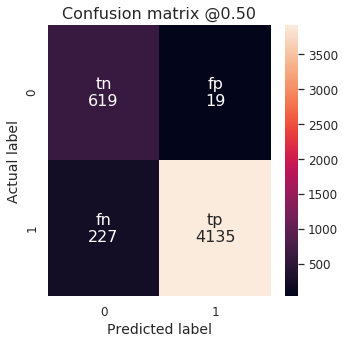

In [26]:
plot_cm(train_labels_baseline, train_predictions_baseline)
plt.savefig(conf["log_dir"]+"/baseline_cm_plot")

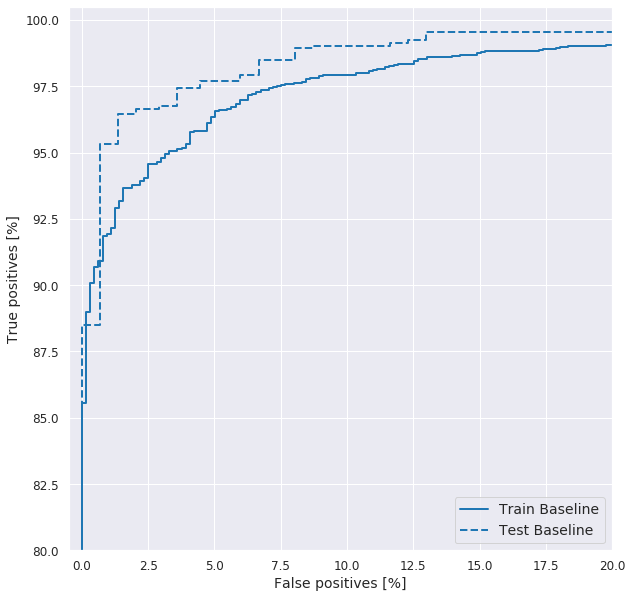

In [27]:
plt.figure(figsize=(10,10))

plot_roc("Train Baseline", train_labels_baseline, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", val_labels_baseline, val_predictions_baseline, color=colors[0], linestyle='--')

plt.legend(loc='lower right');
plt.savefig(conf["log_dir"]+"/baseline_roc_plot.pdf", format="pdf")

### Calculate class weights
See https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights

In [28]:
weight_for_0 = (1/conf["neg_count"])*(conf["sizes"]["total"])/2.0
weight_for_1 = (1/conf["pos_count"])*(conf["sizes"]["total"])/2.0

class_weight = {0: weight_for_0,
                1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 4.00
Weight for class 1: 0.57


In [29]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_ds,
    steps_per_epoch = conf["steps"]["train"],
    epochs = conf["num_epochs"],
    validation_data = test_ds,
    validation_steps = conf["steps"]["test"],
    validation_freq = 1,
    class_weight = class_weight,
    callbacks = callbacks
)

Epoch 1/20
350/350 [==============================] - 21s 60ms/step - loss: 0.2555 - tp: 5348.0000 - fp: 57.0000 - tn: 816.0000 - fn: 579.0000 - accuracy: 0.9065 - precision: 0.9895 - recall: 0.9023 - auc: 0.9699 - val_loss: 0.3603 - val_tp: 1060.0000 - val_fp: 140.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.8833 - val_precision: 0.8833 - val_recall: 1.0000 - val_auc: 0.7489
Epoch 2/20
350/350 [==============================] - 22s 62ms/step - loss: 0.1931 - tp: 4458.0000 - fp: 40.0000 - tn: 692.0000 - fn: 410.0000 - accuracy: 0.9196 - precision: 0.9911 - recall: 0.9158 - auc: 0.9765 - val_loss: 0.3714 - val_tp: 932.0000 - val_fp: 53.0000 - val_tn: 87.0000 - val_fn: 128.0000 - val_accuracy: 0.8492 - val_precision: 0.9462 - val_recall: 0.8792 - val_auc: 0.8802
Epoch 3/20
350/350 [==============================] - 20s 57ms/step - loss: 0.2055 - tp: 4501.0000 - fp: 33.0000 - tn: 699.0000 - fn: 367.0000 - accuracy: 0.9286 - precision: 0.9927 - recall: 0.9246 - auc: 0.9

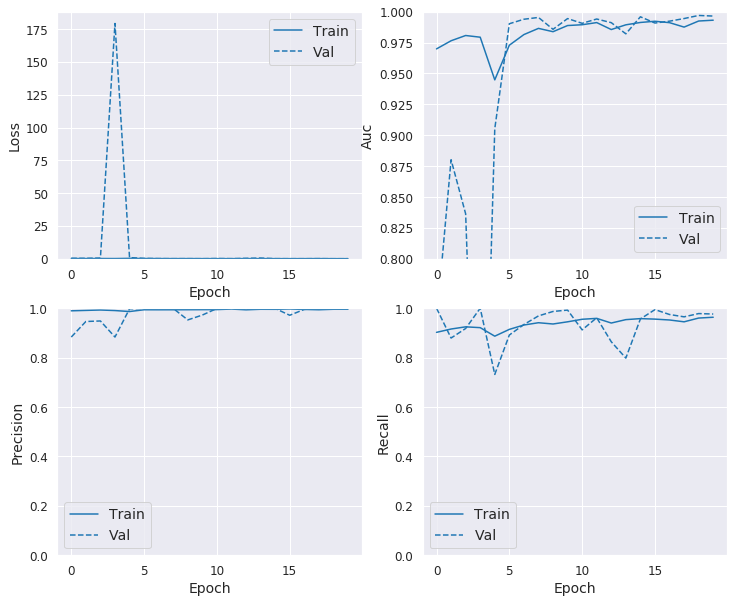

In [30]:
plot_metrics(weighted_history)
plt.savefig(conf["log_dir"]+"/weighted_metrics_plot.pdf", format="pdf")

In [31]:
weighted_results = weighted_model.evaluate(val_ds, verbose=2, steps=conf["steps"]["val"])
print()

f = open(conf["log_dir"]+"/weighted_val_results.txt","w")
for name, value in zip(baseline_model.metrics_names, weighted_results):
    line = "{} : {}\n".format(name, value)
    print(line, end='')
    f.write(line)
f.close()
print()

75/75 - 1s - loss: 0.0737 - tp: 1032.0000 - fp: 1.0000 - tn: 140.0000 - fn: 27.0000 - accuracy: 0.9767 - precision: 0.9990 - recall: 0.9745 - auc: 0.9965

loss : 0.07371287792921066
tp : 1032.0
fp : 1.0
tn : 140.0
fn : 27.0
accuracy : 0.9766666889190674
precision : 0.9990319609642029
recall : 0.9745042324066162
auc : 0.9965007305145264



In [32]:
train_labels_weighted, train_predictions_weighted = numpify(train_ds, weighted_model, samples=5000)
val_labels_weighted, val_predictions_weighted = numpify(val_ds, weighted_model, samples=5000)

Legitimate Lesions Detected (True Negatives):  644
Legitimate Lesions Incorrectly Detected (False Positives):  6
Fraudulent Lesions Missed (False Negatives):  102
Fraudulent Lesions Detected (True Positives):  4248
Total Fraudulent Lesions:  4350



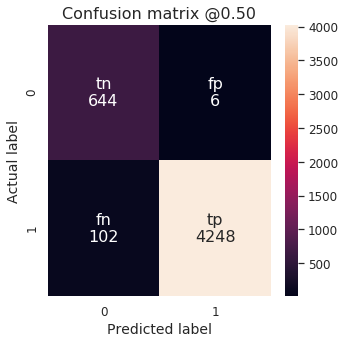

In [33]:
plot_cm(train_labels_weighted, train_predictions_weighted)
plt.savefig(conf["log_dir"]+"/weighted_cm_plot.pdf", format="pdf")

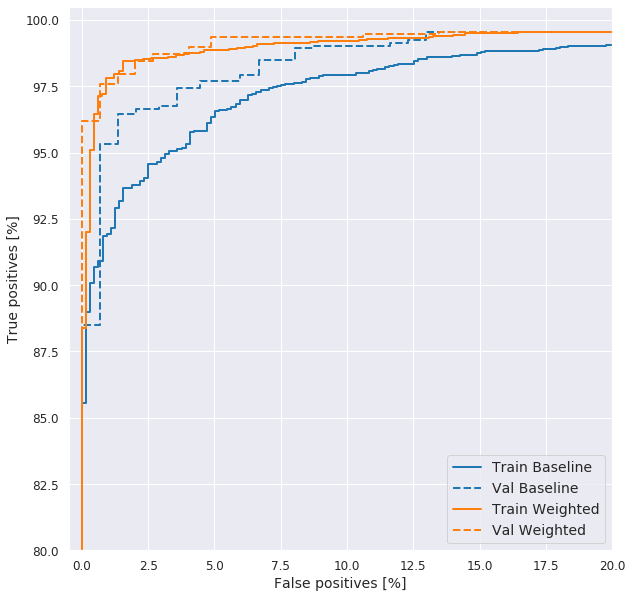

In [34]:
plt.figure(figsize=(10,10))

plot_roc("Train Baseline", train_labels_baseline, train_predictions_baseline, color=colors[0])
plot_roc("Val Baseline", val_labels_baseline, val_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels_weighted, train_predictions_weighted, color=colors[1])
plot_roc("Val Weighted", val_labels_weighted, val_predictions_weighted, color=colors[1], linestyle='--')

plt.legend(loc='lower right');
plt.savefig(conf["log_dir"]+"/weighted_roc_plot.pdf", format="pdf")

## Oversampling the minority class

In [35]:
# Remove the cache
!rm -rf ./cache/*

In [36]:
# Set dataset resample to true to make 5050 distribution of samples
conf["resample"] = True

Create training, testing and validation dataset from utils/data_prep.py

In [37]:
conf["num_classes"] = 2

In [38]:
train_ds_resampled, test_ds_resampled, val_ds_resampled = split_and_create_dataset(conf)


Negative                    :  1000 | 12.50%
---------------------------------------------
     - normal-cecum         :  1000 | 12.50%

Positive                    :  7000 | 87.50%
---------------------------------------------
     - dyed-resection-margins :  1000 | 12.50%
     - normal-z-line        :  1000 | 12.50%
     - esophagitis          :  1000 | 12.50%
     - normal-pylorus       :  1000 | 12.50%
     - polyps               :  1000 | 12.50%
     - ulcerative-colitis   :  1000 | 12.50%
     - dyed-lifted-polyps   :  1000 | 12.50%

Total number of image       : 8000

Dataset.list_files:  /home/henriklg/master-thesis/data/kvasir-v2/*/*.*g 


Full dataset sample size:         8000
Train dataset sample size:        5600
Test dataset sample size:         1200
Validation dataset sample size:   1200

---- Ratios before resampling ---- 
[0.12553571 0.87446429]

---- Ratios after resampling ----
[0.49326172 0.5067383 ]


In [39]:
# Check the mean value is close to 0.5
for img, label in train_ds_resampled.take(3):
    print(label.numpy().mean())

0.5625
0.5
0.5


In [40]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

resampled_history = resampled_model.fit(
    train_ds_resampled,
    steps_per_epoch = conf["steps"]["train"],
    epochs = conf["num_epochs"],
    validation_data = test_ds_resampled,
    validation_steps = conf["steps"]["test"],
    validation_freq = 1,
    callbacks = callbacks
)

Epoch 1/20
350/350 [==============================] - 32s 91ms/step - loss: 0.2401 - tp: 3672.0000 - fp: 230.0000 - tn: 2641.0000 - fn: 257.0000 - accuracy: 0.9284 - precision: 0.9411 - recall: 0.9346 - auc: 0.9748 - val_loss: 0.3613 - val_tp: 1060.0000 - val_fp: 140.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.8833 - val_precision: 0.8833 - val_recall: 1.0000 - val_auc: 0.3872
Epoch 2/20
350/350 [==============================] - 19s 53ms/step - loss: 0.1443 - tp: 2617.0000 - fp: 112.0000 - tn: 2704.0000 - fn: 167.0000 - accuracy: 0.9502 - precision: 0.9590 - recall: 0.9400 - auc: 0.9856 - val_loss: 0.3413 - val_tp: 1060.0000 - val_fp: 140.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.8833 - val_precision: 0.8833 - val_recall: 1.0000 - val_auc: 0.72920 - fp: 106.0000 - tn: 2457.0000 - fn: 151.0000 - accuracy: 0.9492 - precision: 0.9567 - r
Epoch 3/20
350/350 [==============================] - 19s 55ms/step - loss: 0.1044 - tp: 2711.0000 - fp: 83.

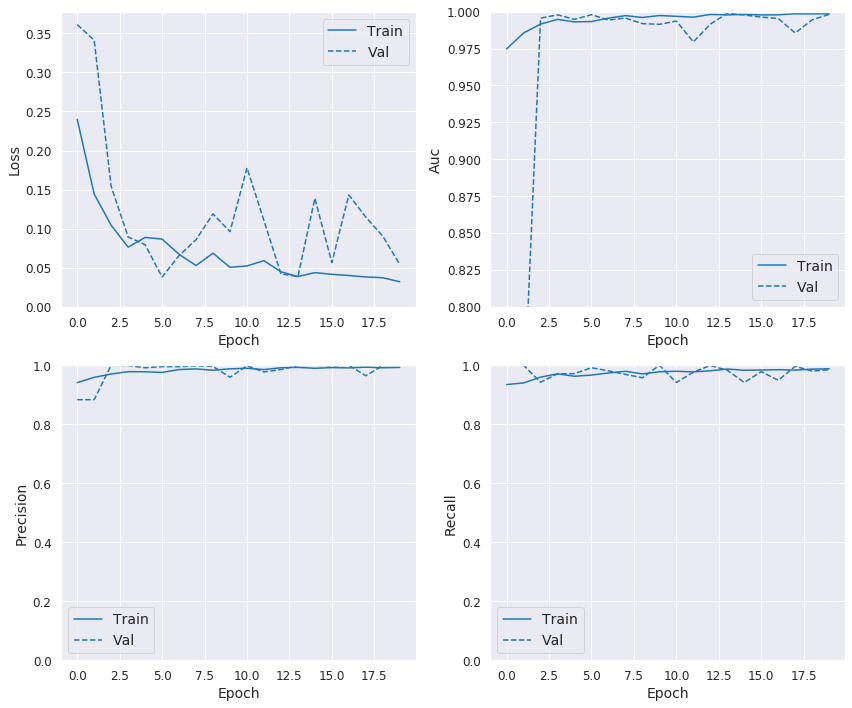

In [49]:
plot_metrics(resampled_history)
plt.savefig(conf["log_dir"]+"/resampled_metrics_plot.pdf", format="pdf")

In [42]:
resampled_results = resampled_model.evaluate(val_ds_resampled, verbose=2, steps=conf["steps"]["val"])
print()

f = open(conf["log_dir"]+"/resampled_val_results.txt","w")
for name, value in zip(resampled_model.metrics_names, resampled_results):
    line = "{} : {}\n".format(name, value)
    print(line, end='')
    f.write(line)
f.close()
print()

75/75 - 1s - loss: 0.0630 - tp: 1038.0000 - fp: 1.0000 - tn: 140.0000 - fn: 21.0000 - accuracy: 0.9817 - precision: 0.9990 - recall: 0.9802 - auc: 0.9980

loss : 0.0629805326461792
tp : 1038.0
fp : 1.0
tn : 140.0
fn : 21.0
accuracy : 0.9816666841506958
precision : 0.9990375638008118
recall : 0.980169951915741
auc : 0.9979574084281921



In [43]:
train_labels_resampled, train_predictions_resampled = numpify(train_ds_resampled, resampled_model, samples=5000)
val_labels_resampled, val_predictions_resampled = numpify(val_ds_resampled, resampled_model, samples=5000)

Legitimate Lesions Detected (True Negatives):  2404
Legitimate Lesions Incorrectly Detected (False Positives):  0
Fraudulent Lesions Missed (False Negatives):  44
Fraudulent Lesions Detected (True Positives):  2552
Total Fraudulent Lesions:  2596



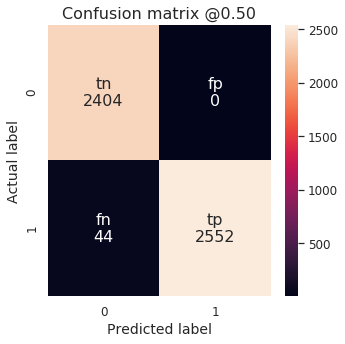

In [44]:
plot_cm(train_labels_resampled, train_predictions_resampled)
plt.savefig(conf["log_dir"]+"/resampled_cm_plot.pdf", format="pdf")

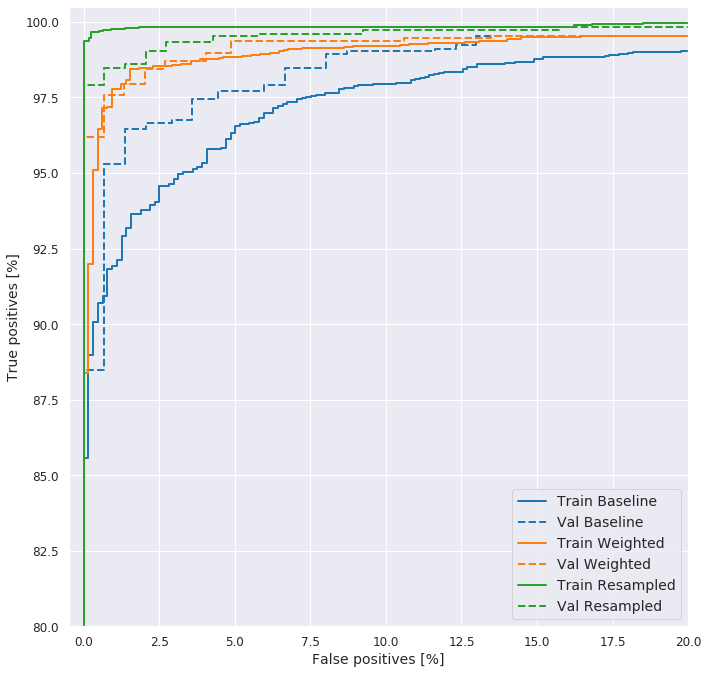

In [52]:
plt.figure(figsize=(10,10))

plot_roc("Train Baseline", train_labels_baseline, train_predictions_baseline, color=colors[0])
plot_roc("Val Baseline", val_labels_baseline, val_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels_weighted, train_predictions_weighted, color=colors[1])
plot_roc("Val Weighted", val_labels_weighted, val_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", train_labels_resampled, train_predictions_resampled, color=colors[2])
plot_roc("Val Resampled", val_labels_resampled, val_predictions_resampled, color=colors[2], linestyle='--')

plt.legend(loc='lower right');
plt.savefig(conf["log_dir"]+"/resampled_roc_plot.pdf", format="pdf")